In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data from the Excel file
moderator_data = pd.read_excel("./moderator-data.xlsx")

# Display top few rows of dataset
moderator_data.head()

,moderator,market,Productivity,Utilisation %,handling time,accuracy
0,1704427801912322,"[""RO""]",274.5480,1.287250,119688,0.93
1,1712377365906433,"[""KH""]",441.6525,1.157927,102324,0.871
2,1705699742139394,"[""KH""]",366.1500,1.150042,76773,0.87
3,1759969798094866,"[""KH""]",400.3325,1.146969,100732,0.781
4,9060023,"[""GB"", ""IT"", ""IE""]",10.2900,1.133573,340,0.3


# EDA (Moderator Dataset)
Below are the column definitions for easy reference:

`moderator`: reviewer/moderator identifier

`market`: reviewer reviews ads delivered to these countries

`Productivity`: how many tasks can the reviewer review in a day, higher is better

`Utilisation %`: how much of the time each day is used for actual review work, higher is better

`handling time`: how much time does reviewing one task cost, lower is better

`accuracy`: probability of getting a task reviewed/decisioned correctly, higher is better

# General Overview

In [40]:
# Getting a brief overview of the dataset
data_overview = {
    "Number of Rows": moderator_data.shape[0],
    "Number of Columns": moderator_data.shape[1],
    "Column Names": moderator_data.columns.tolist(),
    "Data Types": moderator_data.dtypes.tolist(),
    "Missing Values": moderator_data.isnull().sum().tolist()
}

data_overview_df = pd.DataFrame(data_overview)
data_overview_df

,Number of Rows,Number of Columns,Column Names,Data Types,Missing Values
0,1414,6,moderator,int64,0
1,1414,6,market,object,0
2,1414,6,Productivity,float64,129
3,1414,6,Utilisation %,float64,129
4,1414,6,handling time,int64,0
5,1414,6,accuracy,object,0


As seen above, missing values have been identified in the `Productivity` and `Utilisation %` columns.

# Imputing Missing Values

In [41]:
# Imputing missing values for 'Productivity' and 'Utilisation %'
moderator_data['Productivity'].fillna(moderator_data['Productivity'].mean(), inplace=True)
moderator_data['Utilisation %'].fillna(moderator_data['Utilisation %'].median(), inplace=True)

# Renaming the accuracy column to remove extra spaces
moderator_data.rename(columns={' accuracy ': 'accuracy'}, inplace=True)

# Replacing the string value with NaN and converting the column to float type
moderator_data['accuracy'] = pd.to_numeric(moderator_data['accuracy'].replace('                 -  ', np.nan))


# Checking for duplicates
duplicate_rows = moderator_data.duplicated().sum()
duplicate_rows

0

The missing values in `Productivity` and `Utilisation %` have been imputed as 0. The above also shows that there are no duplicate rows in the dataset. 

# Descriptive Analysis

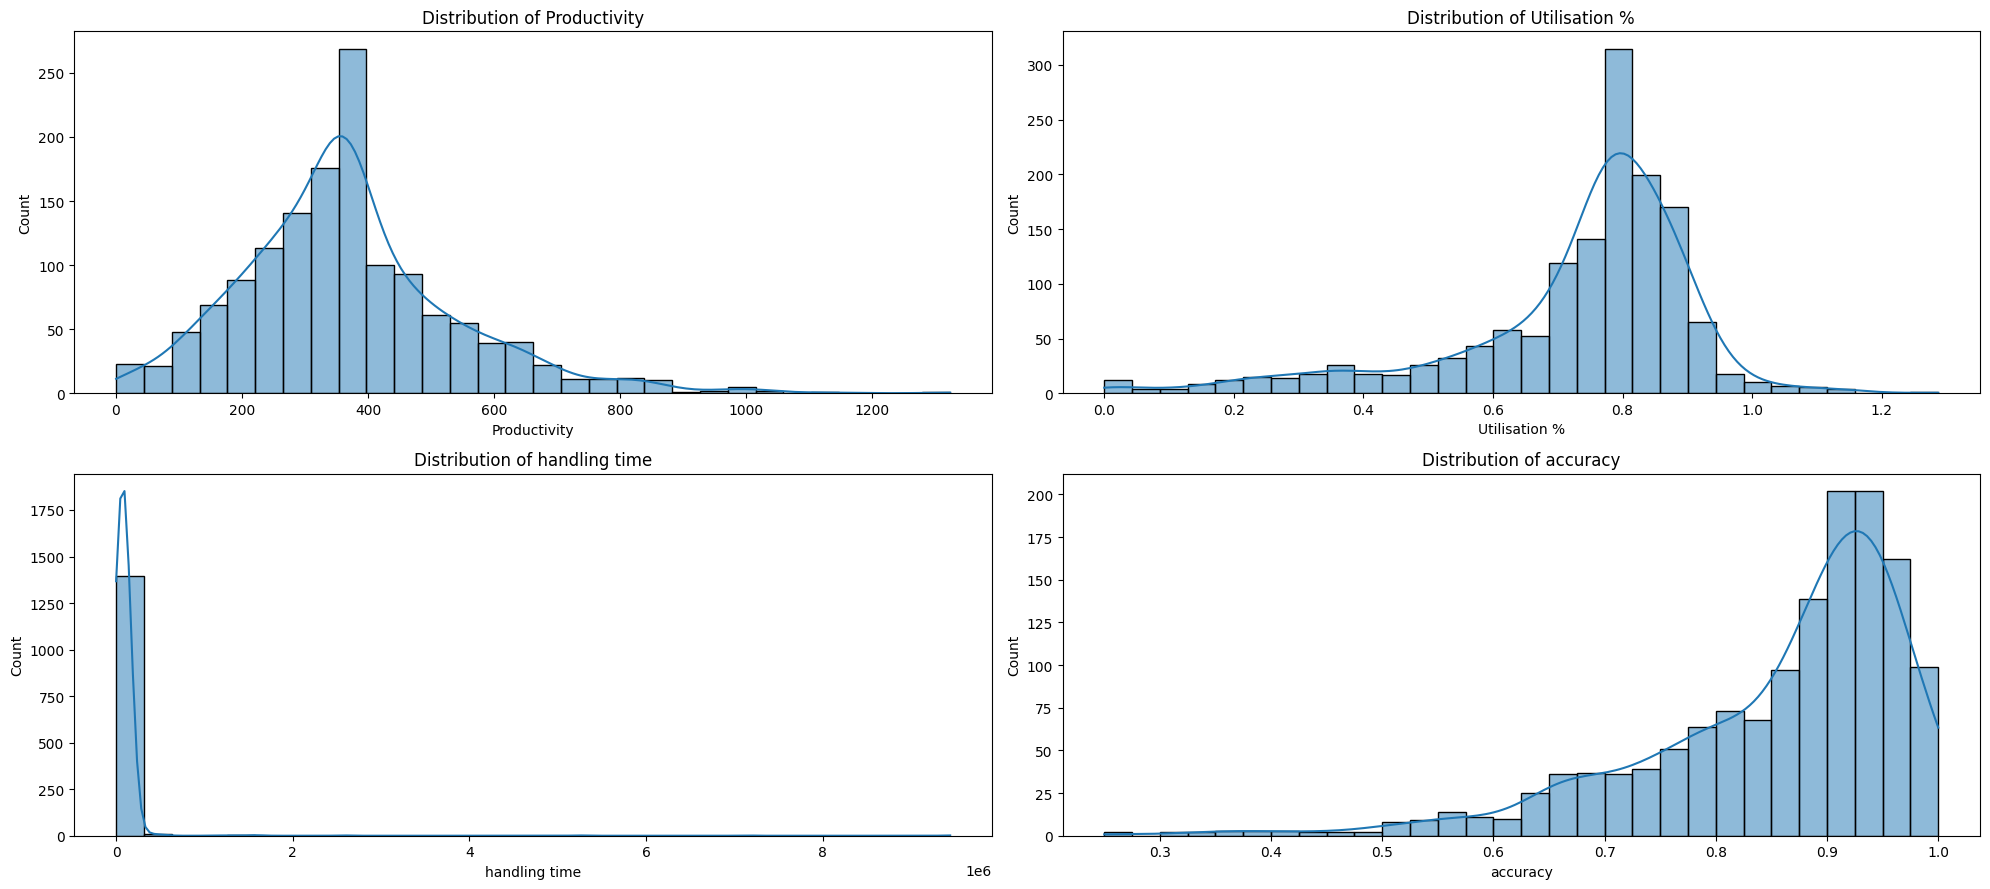

,Productivity,Utilisation %,handling time,accuracy
count,1414.000000,1414.000000,1.414000e+03,1403.000000
mean,366.484054,0.727996,9.681603e+04,0.853531
std,170.307383,0.188907,3.572110e+05,0.122263
min,0.540000,0.000000,0.000000e+00,0.250000
25%,261.674375,0.681149,4.913700e+04,0.796500
50%,362.949231,0.779014,8.135100e+04,0.893000
75%,446.047500,0.843051,1.000525e+05,0.939000
max,1323.355000,1.287250,9.443621e+06,1.000000


In [42]:
# Adjusting the performance metrics list to exclude 'accuracy'
performance_metrics = ['Productivity', 'Utilisation %', 'handling time', 'accuracy']

# Descriptive statistics for the adjusted performance metrics
descriptive_stats = moderator_data[performance_metrics].describe()

# Plotting the distributions of the adjusted performance metrics
plt.figure(figsize=(20, 9))

for i, metric in enumerate(performance_metrics, 1):
    plt.subplot(2, 2, i)
    sns.histplot(moderator_data[metric], bins=30, kde=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

descriptive_stats

1. `Productivity`
- Ranges from 0.54 to 1323.36, with an average of 366.48
- The distribution shows that most reviewers have a productivity between 200 and 500, with a few outliers on the higher end

2. `Utilisation %`
- Ranges from 0% to approximately 1.29%, with an average of 0.728%
- The distribution indicates that most reviewers have a utilization percentage between 0.6% and 0.8%.

3. `Handling Time`
- The values vary widely, with a minimum of 0 and a maximum of 9,443,621 (which is a significant outlier and likely an erroneous data point)
- The distribution is right-skewed with most reviewers having a handling time below 200,000.

4. `Accuracy`
- Most reviewers have a relatively high accuracy between 0.79 to 0.94
- 11 reviewers do not have an accuracy score, likely due to little reviews, these values have been imputed with NaN

# Analysis of Metrics by Market

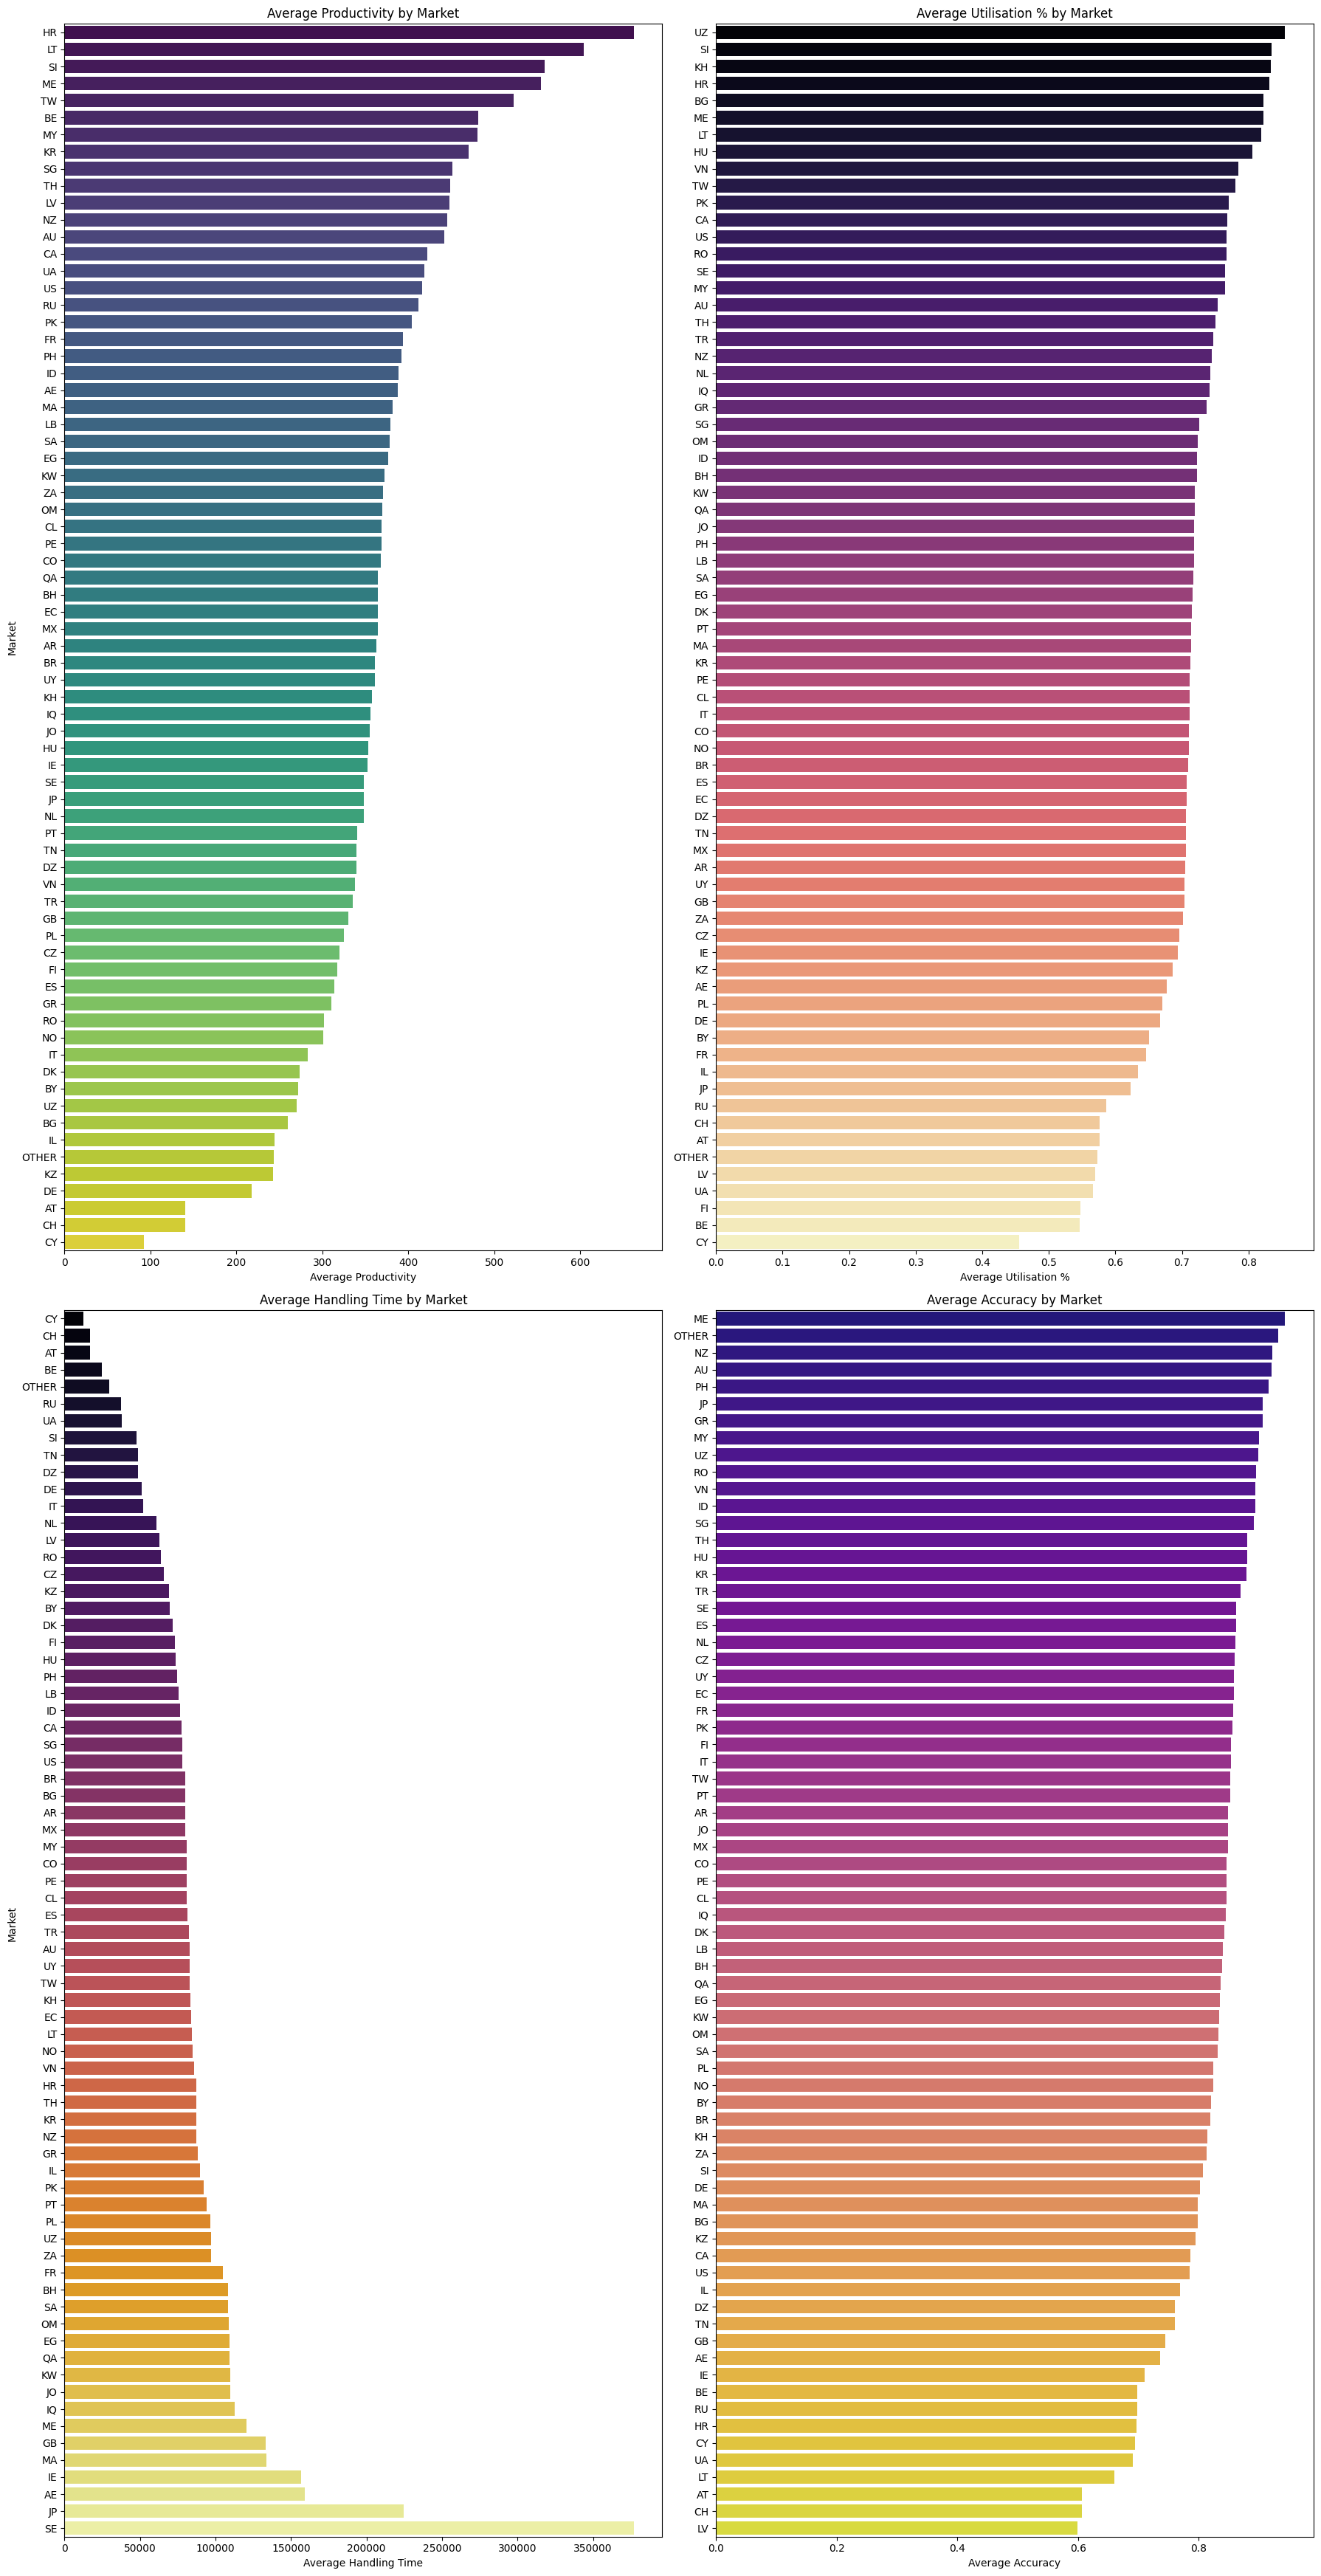

In [49]:
# Splitting the market strings into lists and exploding the DataFrame to treat each market individually
exploded_data = moderator_data.copy()
# Removing brackets from the market strings and splitting again
exploded_data['market'] = exploded_data['market'].str.replace('[\[\]"]', '', regex=True).str.split(', ')

# Exploding the DataFrame again to treat each market individually
exploded_data = exploded_data.explode('market')

# Average performance metrics by market after the adjustment
market_performance_adjusted = exploded_data.groupby('market').agg({
    'Productivity': 'mean',
    'Utilisation %': 'mean',
    'handling time': 'mean',
    'accuracy': 'mean'
}).reset_index().sort_values(by='Productivity', ascending=False)

# Plotting average performance metrics by market
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 35))

sns.barplot(data=market_performance_adjusted, y='market', x='Productivity', ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Average Productivity by Market')
axes[0, 0].set_xlabel('Average Productivity')
axes[0, 0].set_ylabel('Market')

sns.barplot(data=market_performance_adjusted, y='market', x='Utilisation %', ax=axes[0, 1], palette="magma", 
            order=market_performance_adjusted.sort_values('Utilisation %', ascending=False)['market'])
axes[0, 1].set_title('Average Utilisation % by Market')
axes[0, 1].set_xlabel('Average Utilisation %')
axes[0, 1].set_ylabel('')

sns.barplot(data=market_performance_adjusted, y='market', x='handling time', ax=axes[1, 0], palette="inferno", 
            order=market_performance_adjusted.sort_values('handling time', ascending=True)['market'])
axes[1, 0].set_title('Average Handling Time by Market')
axes[1, 0].set_xlabel('Average Handling Time')
axes[1, 0].set_ylabel('Market')

sns.barplot(data=market_performance_adjusted, y='market', x='accuracy', ax=axes[1, 1], palette="plasma", 
            order=market_performance_adjusted.sort_values('accuracy', ascending=False)['market'])
axes[1, 1].set_title('Average Accuracy by Market')
axes[1, 1].set_xlabel('Average Accuracy')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()


1. Average `Productivity` by Market: The "HR" market is the most productive, and the "CR" market is the least productive.

2. Average `Utilisation %` by Market: The "UZ" market has the highest utilization, while the "CY" market continues to have the lowest.

3. Average `Handling Time` by Market: The "CY" market has the shortest handling time, while the "SE" market's moderators take the longest time.

4. Average `Accuracy` by Market: The "ME" market still leads in terms of accuracy, while the "LV" market has the lowest accuracy.

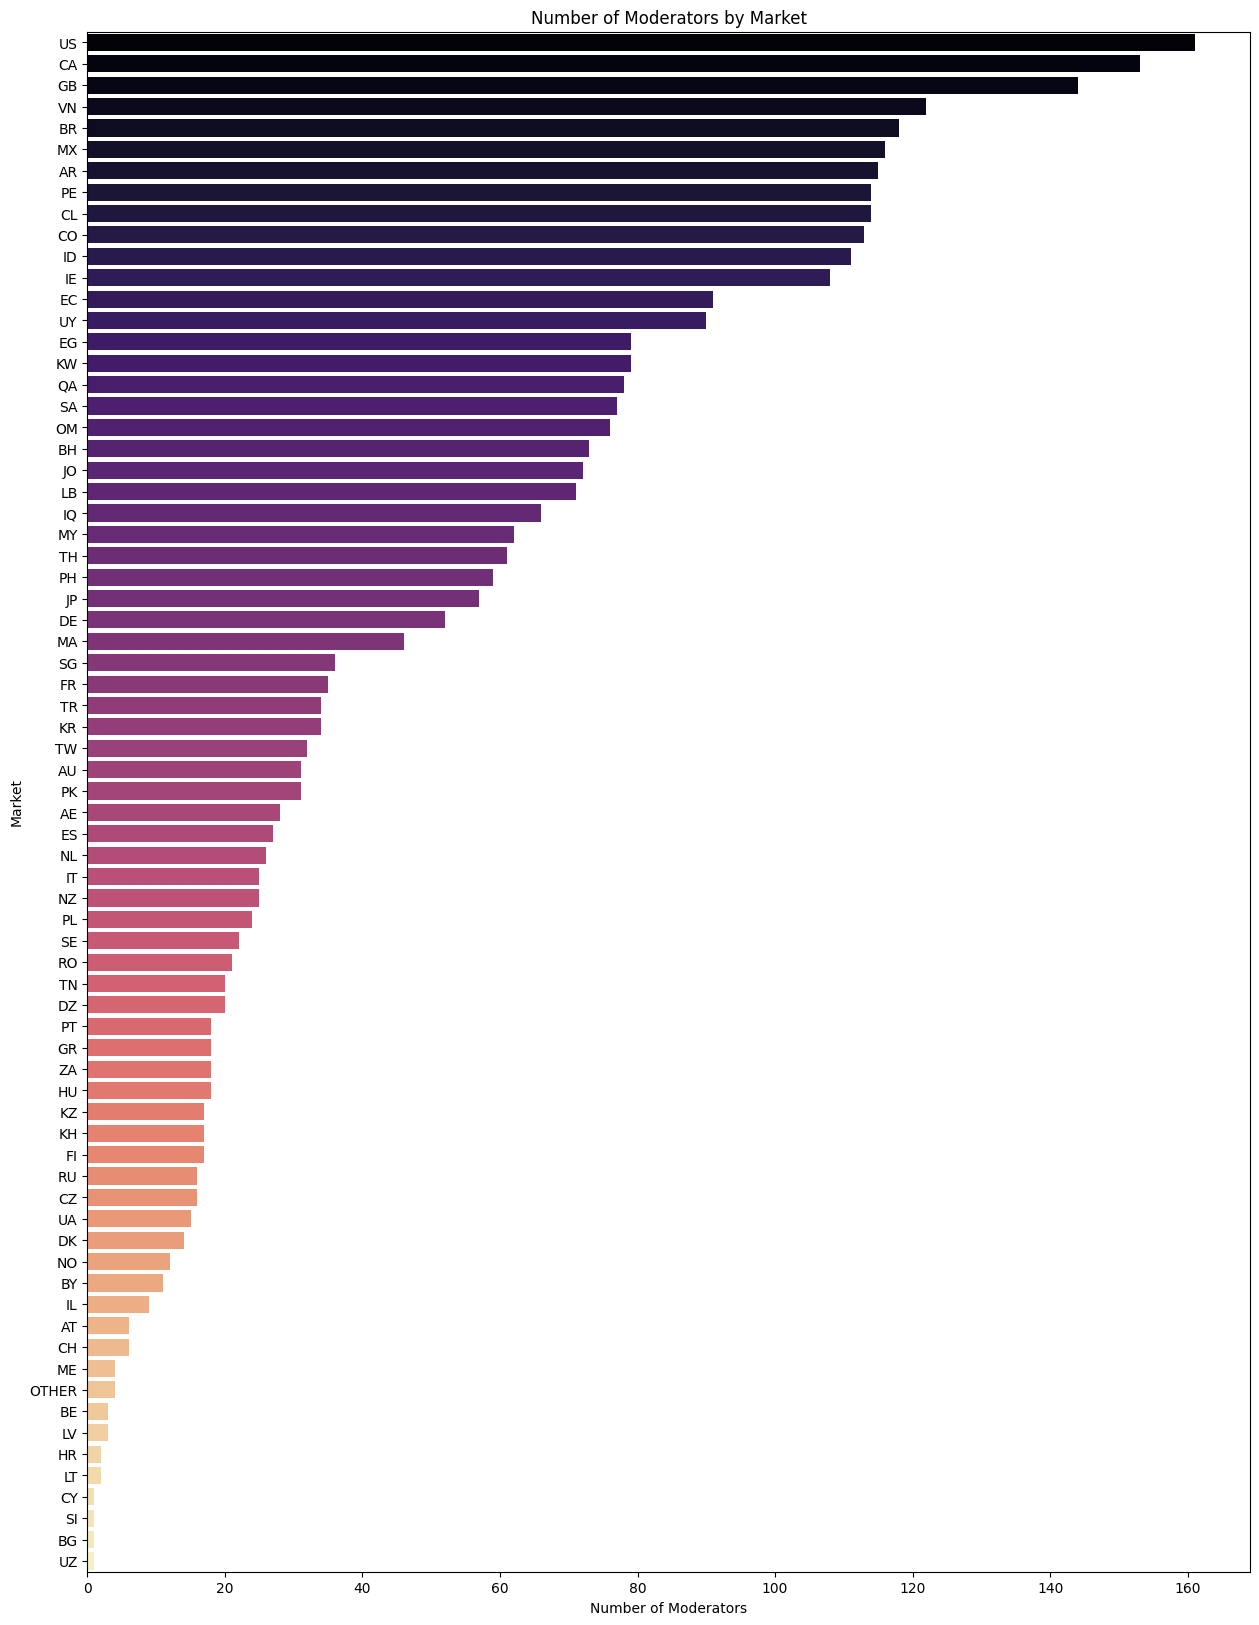

In [53]:
# Counting the number of moderators for each market
market_moderator_counts = exploded_data.groupby('market')['moderator'].nunique().reset_index().sort_values(by='moderator', ascending=False)

# Plotting the number of moderators by market
plt.figure(figsize=(15, 20))
sns.barplot(data=market_moderator_counts, y='market', x='moderator', palette="magma")
plt.title('Number of Moderators by Market')
plt.xlabel('Number of Moderators')
plt.ylabel('Market')
plt.show()

- The "US" market has the most moderators, followed closely by "CA" and "GB", these are English speaking countries
- "BG" and "UZ" have among the fewest moderators.

# Correlation Matrix

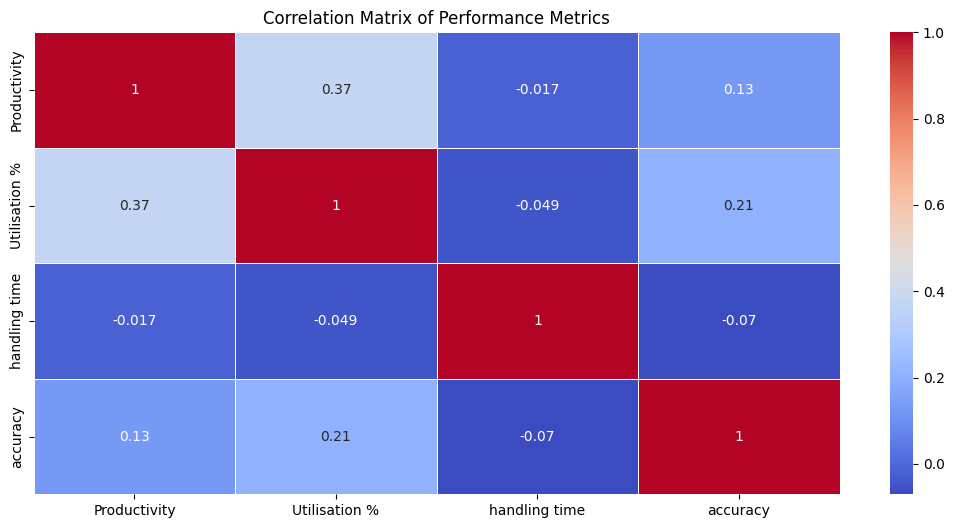

,Productivity,Utilisation %,handling time,accuracy
Productivity,1.000000,0.372293,-0.016724,0.129743
Utilisation %,0.372293,1.000000,-0.048615,0.207093
handling time,-0.016724,-0.048615,1.000000,-0.070293
accuracy,0.129743,0.207093,-0.070293,1.000000


In [51]:
# Redefining the performance metrics list
performance_metrics = ['Productivity', 'Utilisation %', 'handling time', 'accuracy']

# Correlation analysis between performance metrics
correlation_matrix = moderator_data[performance_metrics].corr()

plt.figure(figsize=(13, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix of Performance Metrics')
plt.show()

correlation_matrix

1. `Productivity` & `Utilisation %`:
- There's a positive correlation of 0.37 between productivity and utilization percentage
- This suggests that as reviewers use more of their time for actual review work, their productivity tends to increase, but that strongly

2. `Productivity` & `Handling Time`:
- The correlation is -0.0167, which is close to zero 
- This indicates a very weak negative relationship between productivity and handling time

3. `Utilisation %` & `Handling Time`:
- The correlation is -0.0486, again indicating a very weak negative relationship between utilization percentage and handling time

4. `Accuracy`:
- Strongest positive correlation of 0.21 with utilization percentage, which means that moderators that spend more time on review work would achieve higher accuracy, which is logical
- Weak positive correlation of 0.13 with productivity and weak negative correlation of -0.07 with handling time